In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
plt.style.use("ggplot")

mpl.rcParams["axes.titlesize"] = 11
mpl.rcParams["axes.titlecolor"] = "#333333"
mpl.rcParams["legend.facecolor"] = "#fbfbfb"

In [3]:
figs_dir = Path("..") / "figs"

if not figs_dir.is_dir():
    figs_dir.mkdir(parents=True)

In [4]:
figs_dpi = 300

In [5]:
engine_to_str = {
    "choclo": "SimPEG w/ Choclo",
    "geoana": "SimPEG v0.20",
}

# Plot results against number of receivers

In [6]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-receivers.nc"

In [7]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset> Size: 826B
Dimensions:          (n_receivers: 6, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_receivers      (n_receivers) int32 24B 400 1600 3600 6400 10000 14400
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
  * engine           (engine) object 16B 'choclo' 'geoana'
  * parallel         (parallel) bool 2B False True
Data variables:
    times            (parallel, simulation_type, engine, n_receivers) float64 384B ...
    errors           (parallel, simulation_type, engine, n_receivers) float64 384B ...
Attributes:
    n_cells:  27000

In [8]:
fname = results_dir / "benchmark_dask-n-receivers.nc"
dataset_dask = xr.load_dataset(fname)
dataset_dask

<xarray.Dataset> Size: 232B
Dimensions:          (n_receivers: 6, simulation_type: 2)
Coordinates:
  * n_receivers      (n_receivers) int32 24B 400 1600 3600 6400 10000 14400
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
Data variables:
    times            (simulation_type, n_receivers) float64 96B 1.683 ... 92.62
    errors           (simulation_type, n_receivers) float64 96B 0.2424 ... 1.031
Attributes:
    n_cells:  27000

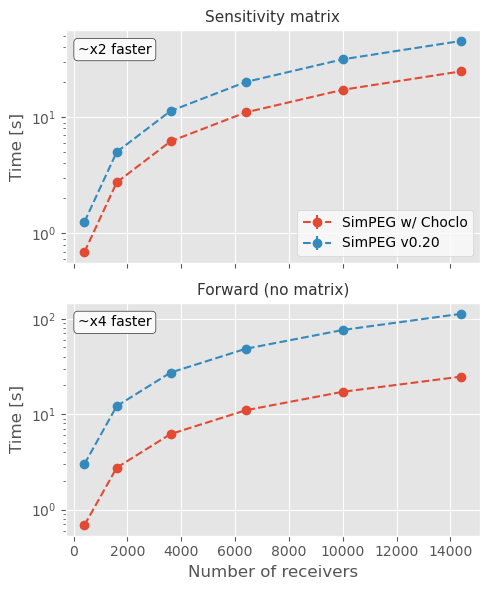

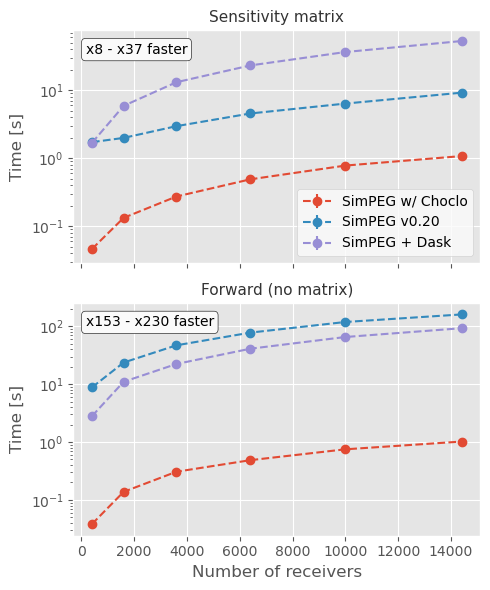

In [9]:
for parallel in (False, True):
    ncols, nrows = 1, 2
    figsize = (5, 6)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

    for row, simulation_type in zip(range(nrows), dataset.simulation_type):
        ax = axes[row]
        
        # Plot benchmark results
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )
            ax.errorbar(
                x=results.n_receivers,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_to_str[str(engine.values)],
            )
            
        # Plot benchmarks with Dask
        if parallel:
            results = dataset_dask.sel(simulation_type=simulation_type)
            ax.errorbar(
                x=results.n_receivers,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label="SimPEG + Dask",
            )
            
        # Set title
        sim_type_str = str(simulation_type.values)
        if sim_type_str == "forward_only":
            sim_type_str = "Forward (no matrix)"
        elif sim_type_str == "ram":
            sim_type_str = "Sensitivity matrix"
        ax.set_title(sim_type_str)

        if row == 1:
            ax.set_xlabel("Number of receivers")
        ax.set_ylabel("Time [s]")

        # Annotate ratio
        times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
        ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
        vmin, vmax = np.min(ratio.values), np.max(ratio.values)
        if vmax / vmin < 1.4:
            text = f"~x{round(np.mean(ratio.values))} faster"
        else:
            text = f"x{round(vmin)} - x{round(vmax)} faster"

        ha = "left"
        if row == 0:
            loc = (0.03, 0.9)
        else:
            loc = (0.03, 0.9)

        ax.annotate(
            text,
            loc,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
            ha=ha,
        )
        # ----------------

        # Add legend
        if row == 0:
            ax.legend(loc="lower right")

        # Set yscales
        ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"

    plt.savefig(figs_dir / f"benchmark_n-receivers_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

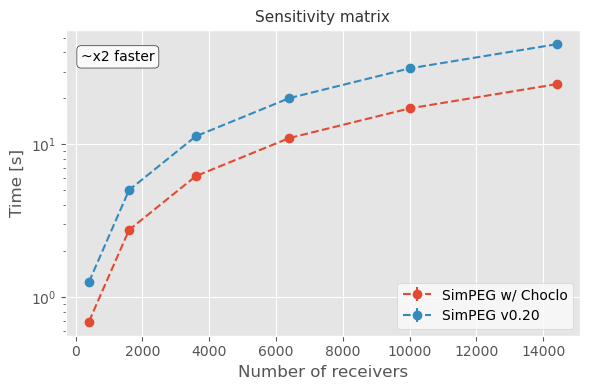

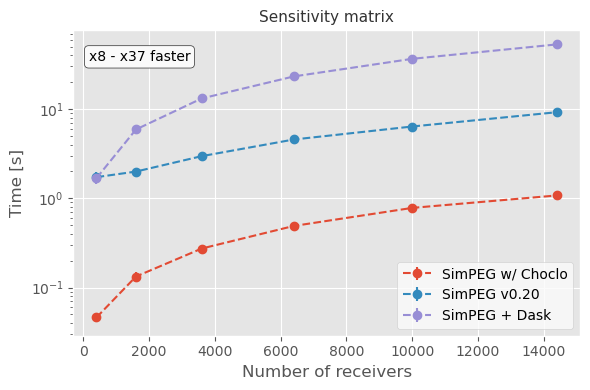

In [10]:
simulation_type = "ram"
figsize = (6, 4)


for parallel in (False, True):
    
    fig, ax = plt.subplots(figsize=figsize)

        
    # Plot benchmark results
    for engine in dataset.engine:
        results = dataset.sel(
            engine=engine, simulation_type=simulation_type, parallel=parallel
        )

        ax.errorbar(
            x=results.n_receivers,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )

    # Plot benchmarks with Dask
    if parallel:
        results = dataset_dask.sel(simulation_type=simulation_type)
        ax.errorbar(
            x=results.n_receivers,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label="SimPEG + Dask",
        )

    # Set title
    ax.set_title("Sensitivity matrix")

    ax.set_xlabel("Number of receivers")
    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    ha = "left"
    loc = (0.03, 0.9)
    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ----------------

    # Add legend
    ax.legend(loc="lower right")
    
    # Set yscales
    ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"

    plt.savefig(figs_dir / f"benchmark_n-receivers_sensitivities_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

# Plot results against number of cells in the mesh

In [11]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-cells.nc"

In [12]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset> Size: 694B
Dimensions:          (n_cells: 5, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_cells          (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
  * engine           (engine) object 16B 'choclo' 'geoana'
  * parallel         (parallel) bool 2B False True
Data variables:
    times            (parallel, simulation_type, engine, n_cells) float64 320B ...
    errors           (parallel, simulation_type, engine, n_cells) float64 320B ...
Attributes:
    n_receivers:  2500

In [13]:
fname = results_dir / "benchmark_dask-n-cells.nc"
dataset_dask = xr.load_dataset(fname)
dataset_dask

<xarray.Dataset> Size: 196B
Dimensions:          (n_cells: 5, simulation_type: 2)
Coordinates:
  * n_cells          (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
Data variables:
    times            (simulation_type, n_cells) float64 80B 8.123 ... 162.3
    errors           (simulation_type, n_cells) float64 80B 0.174 ... 0.06972
Attributes:
    n_receivers:  2500

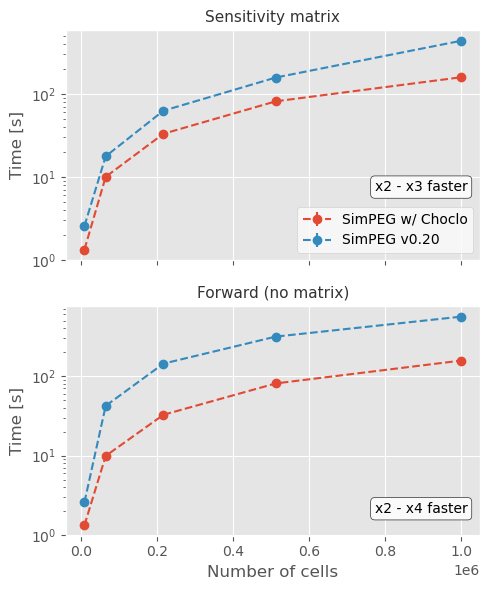

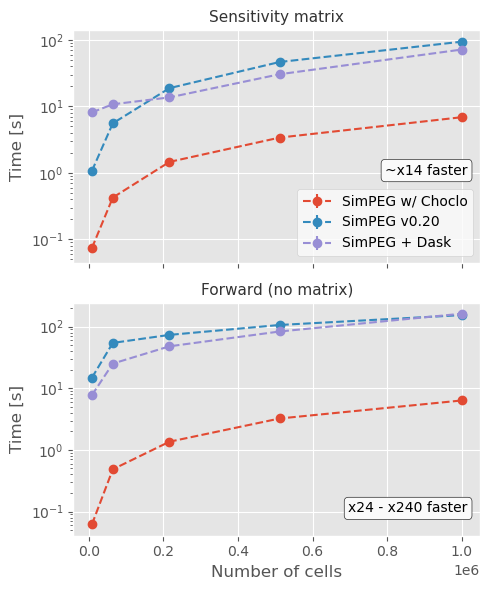

In [14]:
for parallel in (False, True):
    ncols, nrows = 1, 2
    figsize = (5, 6)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

    for row, simulation_type in zip(range(nrows), dataset.simulation_type):
        ax = axes[row]
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )
            ax.errorbar(
                x=results.n_cells,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_to_str[str(engine.values)],
            )
            
        if parallel:
            # Plot benchmarks with Dask
            results = dataset_dask.sel(simulation_type=simulation_type)
            ax.errorbar(
                x=results.n_cells,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label="SimPEG + Dask",
            )
            
        sim_type_str = str(simulation_type.values)
        if sim_type_str == "forward_only":
            sim_type_str = "Forward (no matrix)"
        elif sim_type_str == "ram":
            sim_type_str = "Sensitivity matrix"
        ax.set_title(sim_type_str)
        
        ax.set_ylabel("Time [s]")
        if row == 1:
            ax.set_xlabel("Number of cells")

        # Annotate ratio
        times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
        ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
        vmin, vmax = np.min(ratio.values), np.max(ratio.values)
        if vmax / vmin < 1.4:
            text = f"~x{round(np.mean(ratio.values))} faster"
        else:
            text = f"x{round(vmin)} - x{round(vmax)} faster"

        if not parallel:
            if row == 0:
                loc = (0.97, 0.3)
            else:
                loc = (0.97, 0.1)
        else:
            if row == 0:
                loc = (0.97, 0.38)
            else:
                loc = (0.97, 0.1)
        ha = "right"

        ax.annotate(
            text,
            loc,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
            ha=ha,
        )
        # ---------------------------------

        # Add legend
        if row == 0:
            ax.legend(loc="lower right")

        # Set yscales
        ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"
    plt.savefig(figs_dir / f"benchmark_n-cells_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

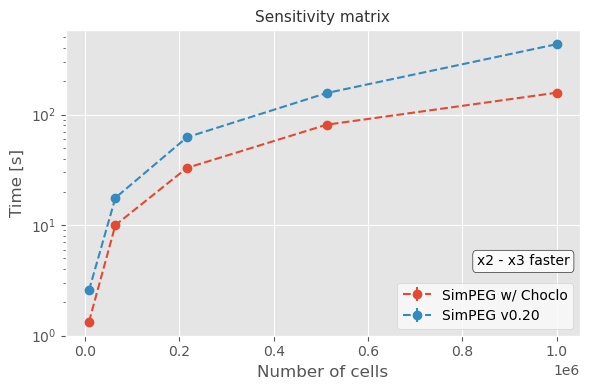

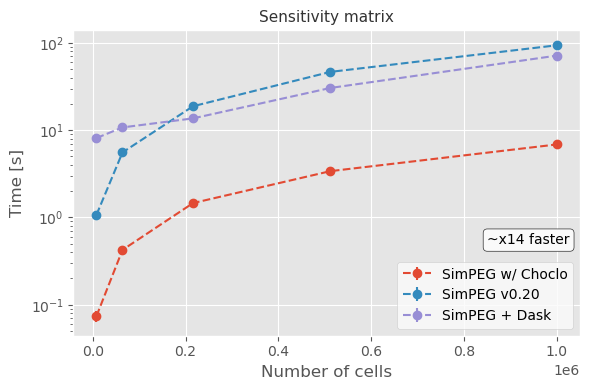

In [15]:
figsize = (6, 4)
simulation_type = "ram"

for parallel in (False, True):
    fig, ax = plt.subplots(figsize=figsize)

    for engine in dataset.engine:
        results = dataset.sel(
            engine=engine, simulation_type=simulation_type, parallel=parallel
        )
        ax.errorbar(
            x=results.n_cells,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )
        
    if parallel:
        # Plot benchmarks with Dask
        results = dataset_dask.sel(simulation_type=simulation_type)
        ax.errorbar(
            x=results.n_cells,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label="SimPEG + Dask",
        )
            

    ax.set_title("Sensitivity matrix")
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    if parallel:
        loc = (0.98, 0.3)
    else:
        loc = (0.98, 0.23)
    ha = "right"
    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ---------------------------------

    # Add legend
    ax.legend(loc="lower right")

    # Set yscales
    ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"
    plt.savefig(figs_dir / f"benchmark_n-cells_sensitivities_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

# Plot results against number of processors used

In [16]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-processes.nc"

In [17]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset> Size: 440B
Dimensions:          (n_processes: 6, simulation_type: 2, engine: 2)
Coordinates:
  * n_processes      (n_processes) int32 24B 1 5 10 20 30 48
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
  * engine           (engine) object 16B 'choclo' 'geoana'
Data variables:
    times            (engine, simulation_type, n_processes) float64 192B 37.5...
    errors           (engine, simulation_type, n_processes) float64 192B 0.01...
Attributes:
    n_cells:      125000
    n_receivers:  4900

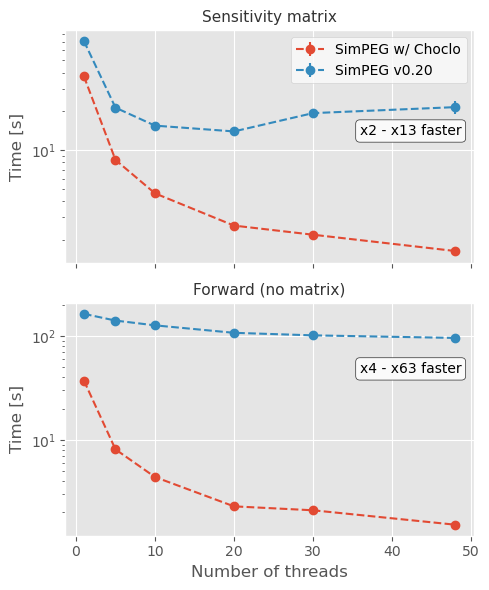

In [18]:
ncols, nrows = 1, 2
figsize = (5, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

for row, simulation_type in zip(range(nrows), dataset.simulation_type):
    ax = axes[row]
    for engine in dataset.engine:
        results = dataset.sel(engine=engine, simulation_type=simulation_type)

        ax.errorbar(
            x=results.n_processes,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )
    sim_type_str = str(simulation_type.values)
    if sim_type_str == "forward_only":
        sim_type_str = "Forward (no matrix)"
    elif sim_type_str == "ram":
        sim_type_str = "Sensitivity matrix"
    ax.set_title(sim_type_str)

    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    if row == 0:
        loc = (0.97, 0.55)
        ha = "right"
    else:
        loc = (0.97, 0.7)
        ha = "right"

    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ---------------------------------

    # Add legend
    if row == 0:
        ax.legend(loc="upper right")
    if row == 1:
        ax.set_xlabel("Number of threads")
    ax.set_yscale("log")

    # Set yscales
    ax.set_yscale("log")

plt.tight_layout()

plt.savefig(figs_dir / "benchmark_n-processes.png", dpi=figs_dpi)

plt.show()

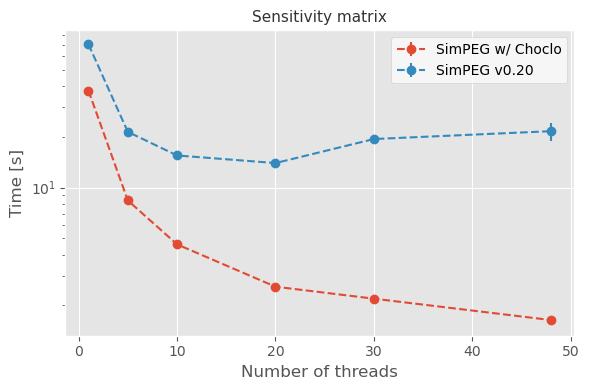

In [19]:
figsize = (6, 4)
fig, ax = plt.subplots(figsize=figsize)
simulation_type = "ram"

for engine in dataset.engine:
    results = dataset.sel(engine=engine, simulation_type=simulation_type)

    ax.errorbar(
        x=results.n_processes,
        y=results.times,
        yerr=results.errors,
        marker="o",
        linestyle="dashed",
        label=engine_to_str[str(engine.values)],
    )
ax.set_title("Sensitivity matrix")
ax.set_xlabel("Number of threads")
ax.set_ylabel("Time [s]")

# Add legend
ax.legend(loc="upper right")
ax.set_yscale("log")

plt.tight_layout()

plt.savefig(figs_dir / "benchmark_n-processes-sensitivities.png", dpi=figs_dpi)

plt.show()

## Large problem

In [20]:
fname = results_dir / "benchmark_large-problem.nc"
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset> Size: 48B
Dimensions:  (engine: 2)
Coordinates:
  * engine   (engine) object 16B 'choclo' 'geoana'
Data variables:
    times    (engine) float64 16B 136.6 1.132e+03
    errors   (engine) float64 16B 0.0 0.0
Attributes:
    n_cells:      1000000
    n_receivers:  90000

In [21]:
dataset.times.sel(engine="geoana") / dataset.times.sel(engine="choclo")

<xarray.DataArray 'times' ()> Size: 8B
array(8.28804414)

In [22]:
fname = results_dir / "benchmark_dask-large-problem.nc"
dataset_dask = xr.load_dataset(fname)
dataset_dask

<xarray.Dataset> Size: 48B
Dimensions:  (engine: 2)
Coordinates:
  * engine   (engine) object 16B 'choclo' 'geoana'
Data variables:
    times    (engine) float64 16B 132.9 451.2
    errors   (engine) float64 16B 0.0 0.0
Attributes:
    n_cells:      1000000
    n_receivers:  90000

In [23]:
dataset_dask.times.sel(engine="geoana") / dataset_dask.times.sel(engine="choclo")

<xarray.DataArray 'times' ()> Size: 8B
array(3.39408793)

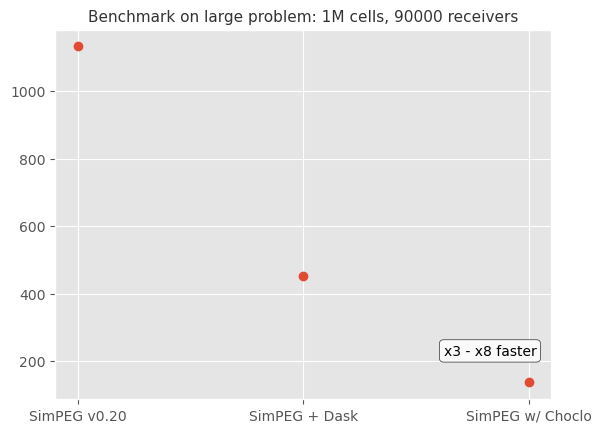

In [24]:
categories = ["SimPEG v0.20", "SimPEG + Dask", "SimPEG w/ Choclo"]
times = np.array(
    [
        dataset.sel(engine="geoana").times.values,
        dataset_dask.sel(engine="geoana").times.values,
        dataset.sel(engine="choclo").times.values,
    ]
)
errors = np.array(
    [
        dataset.sel(engine="geoana").errors.values,
        dataset_dask.sel(engine="geoana").errors.values,
        dataset.sel(engine="choclo").errors.values,
    ]
)

plt.errorbar(x=categories, y=times, yerr=errors, marker="o", linestyle="none")

# Add title
n_cells = f"{dataset.n_cells:.1e}"
if dataset.n_cells == 1e6:
    n_cells = "1M"
plt.title(
    f"Benchmark on large problem: {n_cells} cells, "
    f"{dataset.n_receivers} receivers"
)


# Annotate speed ratio
ratii = [times[0] / times[-1], times[1] / times[-1]]
text = f"x{round(np.min(ratii))} - x{round(np.max(ratii))} faster"
loc = (0.97, 0.12)
ha = "right"
plt.annotate(
    text,
    loc,
    xycoords="axes fraction",
    bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
    ha=ha,
)

plt.show()

Get memory usage results

In [25]:
engines = ("choclo", "geoana", "dask")
memory_peaks = {}

for engine in engines:
    fname = results_dir / f"memory-{engine}"
    with open(fname, "r") as f:
        for line in f:
            if "Maximum resident set size" in line:
                peak = int(line.split()[-1])
                memory_peaks[engine] = peak
                break
memory_peaks

{'choclo': 352474272, 'geoana': 703550516, 'dask': 356964660}

Convert to GB

In [26]:
for engine, peak in memory_peaks.items():
    print(f"{engine}: {peak / 1024 ** 2:.2f} GB")

choclo: 336.15 GB
geoana: 670.96 GB
dask: 340.43 GB


## Figures to go with magnetic benchmarks

Generate figures that can be put side to side with the magnetic benchmarks, keeping similar style.

In [27]:
def get_ratii_text(ratii):
    vmin, vmax = np.nanmin(ratii.values), np.nanmax(ratii.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratii.values))} faster"
    else:
        text = f"x{format_ratio(vmin)} - x{format_ratio(vmax)} faster"
    return text

def get_simpler_label(engine, field=None):
    """Generate label for plot legends."""
    match engine:
        case "geoana":
            label = "simpeg w/o choclo"
        case "choclo":
            label = "simpeg + choclo"
        case _:
            raise ValueError(f"Invalid engine '{engine}'.")
    if field is not None:
        label += f" ({field})"
    return label

def format_ratio(ratio):
    if ratio < 3:
        return f"{ratio:.1f}"
    return f"{round(ratio)}"


In [28]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-cells.nc"

In [29]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset> Size: 694B
Dimensions:          (n_cells: 5, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_cells          (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
  * engine           (engine) object 16B 'choclo' 'geoana'
  * parallel         (parallel) bool 2B False True
Data variables:
    times            (parallel, simulation_type, engine, n_cells) float64 320B ...
    errors           (parallel, simulation_type, engine, n_cells) float64 320B ...
Attributes:
    n_receivers:  2500

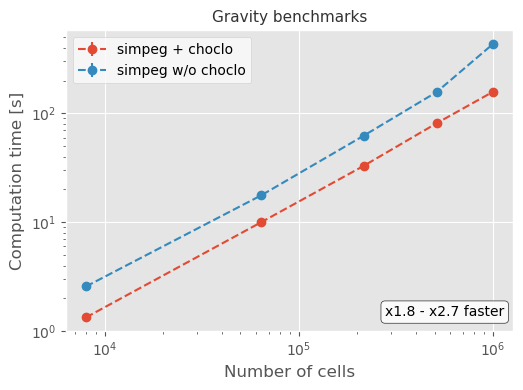

In [30]:
simulation_type = "ram"
parallel = False

fig = plt.figure(figsize=(4 * 4/3, 4))

for engine in dataset.engine:
    results = dataset.sel(
        engine=engine, simulation_type=simulation_type, parallel=parallel
    )
    label = get_simpler_label(engine.values)
    plt.errorbar(
        x=results.n_cells,
        y=results.times,
        yerr=results.errors,
        marker="o",
        linestyle="dashed",
        label=label,
        # label=engine_to_str[str(engine.values)],
    )

# Compute ratii
ratii = (
    dataset.times.sel(engine="geoana", simulation_type=simulation_type, parallel=parallel)
    / dataset.times.sel(engine="choclo", simulation_type=simulation_type, parallel=parallel)
)
text = get_ratii_text(ratii)

loc, ha = (0.98, 0.05), "right"
plt.annotate(
    text,
    loc,
    xycoords="axes fraction",
    bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
    ha=ha,
)

plt.title("Gravity benchmarks")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.legend()

plt.tight_layout()

plt.savefig(
    figs_dir / "benchmark_gravity_single_thread_loglog.png",
    dpi=300,
)
plt.show()

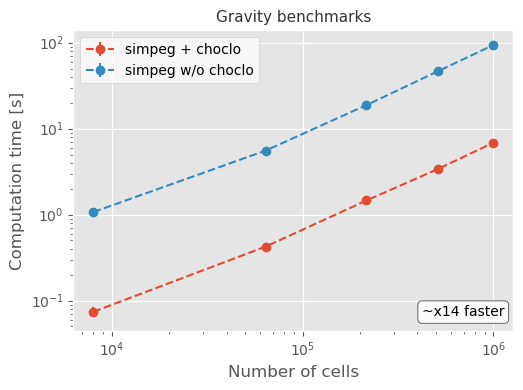

In [31]:
simulation_type = "ram"
parallel = True

fig = plt.figure(figsize=(4 * 4/3, 4))

for engine in dataset.engine:
    results = dataset.sel(
        engine=engine, simulation_type=simulation_type, parallel=parallel
    )
    label = get_simpler_label(engine.values)
    plt.errorbar(
        x=results.n_cells,
        y=results.times,
        yerr=results.errors,
        marker="o",
        linestyle="dashed",
        label=label,
        # label=engine_to_str[str(engine.values)],
    )

# Compute ratii
ratii = (
    dataset.times.sel(engine="geoana", simulation_type=simulation_type, parallel=parallel)
    / dataset.times.sel(engine="choclo", simulation_type=simulation_type, parallel=parallel)
)
text = get_ratii_text(ratii)

loc, ha = (0.98, 0.05), "right"
plt.annotate(
    text,
    loc,
    xycoords="axes fraction",
    bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
    ha=ha,
)

plt.title("Gravity benchmarks")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.legend()

plt.tight_layout()

plt.savefig(
    figs_dir / f"benchmark_gravity_parallel_image.png",
    dpi=300,
)
plt.show()

In [32]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-processes.nc"

In [33]:
threads = xr.load_dataset(fname)
threads

<xarray.Dataset> Size: 440B
Dimensions:          (n_processes: 6, simulation_type: 2, engine: 2)
Coordinates:
  * n_processes      (n_processes) int32 24B 1 5 10 20 30 48
  * simulation_type  (simulation_type) object 16B 'ram' 'forward_only'
  * engine           (engine) object 16B 'choclo' 'geoana'
Data variables:
    times            (engine, simulation_type, n_processes) float64 192B 37.5...
    errors           (engine, simulation_type, n_processes) float64 192B 0.01...
Attributes:
    n_cells:      125000
    n_receivers:  4900

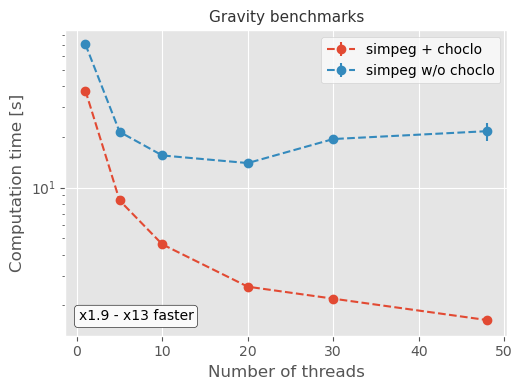

In [34]:
simulation_type = "ram"

fig = plt.figure(figsize=(4 * 4/3, 4))

for engine in threads.engine:
    results = threads.sel(engine=engine, simulation_type=simulation_type)

    plt.errorbar(
        x=results.n_processes,
        y=results.times,
        yerr=results.errors,
        marker="o",
        linestyle="dashed",
        label=get_simpler_label(engine.values),
    )
plt.title("Gravity benchmarks")
plt.xlabel("Number of threads")
plt.ylabel("Computation time [s]")

# Compute ratii
ratii = (
    threads.times.sel(engine="geoana", simulation_type=simulation_type) 
    / threads.times.sel(engine="choclo", simulation_type=simulation_type)
)
text = get_ratii_text(ratii)
plt.annotate(
    text,
    (0.03, 0.05),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
    ha="left",
)

# Add legend
plt.legend(loc="upper right")
plt.yscale("log")

plt.tight_layout()

plt.savefig(figs_dir / "benchmark_gravity_threads.png", dpi=300)
    
plt.show()